In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup & Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA, SparsePCA

import matplotlib.pyplot as plt

import gc

# Directories
dir_meta        = '/content/drive/MyDrive/Comps/Multimodal_Single-Cell_Integration/Data/metadata.parquet'
dir_eval_ids    = '/content/drive/MyDrive/Comps/Multimodal_Single-Cell_Integration/Data/evaluation_ids.csv'

dir_cite_train  = '/content/drive/MyDrive/Comps/Multimodal_Single-Cell_Integration/Data/Cite/Train/train_cite_inputs.parquet'
dir_cite_tar    = '/content/drive/MyDrive/Comps/Multimodal_Single-Cell_Integration/Data/Cite/Train/train_cite_targets.parquet'
dir_cite_test   = '/content/drive/MyDrive/Comps/Multimodal_Single-Cell_Integration/Data/Cite/Test/test_cite_inputs.parquet'

dir_multi_in  = '/content/drive/MyDrive/Comps/Multimodal_Single-Cell_Integration/Data/Multi/train_multi_inputs_values.sparse.npz'
dir_multi_tar = '/content/drive/MyDrive/Comps/Multimodal_Single-Cell_Integration/Data/Multi/train_multi_targets_values.sparse.npz'
dir_multi_test   = '/content/drive/MyDrive/Comps/Multimodal_Single-Cell_Integration/Data/Multi/test_multi_inputs_values.sparse.npz'

dir_multi = '/content/drive/MyDrive/Comps/Multimodal_Single-Cell_Integration/Data/Multi'

# SVD Explore

This sections loads the train and test data as sparse matrices and performs a singular value decomposition. For this competition both the train and test data were transformed before training in order to reduce dimensionality. The excat number of components was found to be optimal around 70. The analysis was conducted by comparing CV scores for different numbers of components.

In [ ]:
# Load train data 
train = scipy.sparse.load_npz(dir_multi_in)

# Get svd of train data 
u, s, vT = scipy.sparse.linalg.svds(train, k=70)

# Transform train data 
train = u.dot(np.diag(s))

# Save train data 
train = pd.DataFrame(train, columns=[f'svd_{x}' for x in range(70)])
train.to_parquet(f'{dir_multi}/train_svd_70.parquet')

# Load test data 
test = scipy.sparse.load_npz(dir_multi_test)

# Transform test data 
test = test @ np.transpose(vT)

# Save test data 
test = pd.DataFrame(test, columns=[f'svd_{x}' for x in range(70)])
test.to_parquet(f'{dir_multi}/test_svd_70.parquet')

In [5]:
# Normalize train target
train_tar = scipy.sparse.load_npz(dir_multi_tar)
train_tar = train_tar.todense()
train_tar -= train_tar.mean(axis=1).reshape(-1, 1)
train_tar /= train_tar.std(axis=1).reshape(-1, 1)
train_tar = np.asarray(train_tar)

# Transform train target
u, s, vT = scipy.sparse.linalg.svds(train_tar, k=512)

# Save train target
train_tar = u.dot(np.diag(s))
train_tar = pd.DataFrame(train_tar, columns = [f'svd_{x}' for x in range(512)])
train_tar.to_parquet(f'{dir_multi}/train_tar_svd_512.parquet')

# Save test inverse
save = pd.DataFrame(vT, columns = [f'svd_inv_{x}' for x in range(23418)])
save.to_parquet(f'{dir_multi}/test_inv_svd_512.parquet')

# Meta Data

Checking distributions of cell types compared to other meta data.

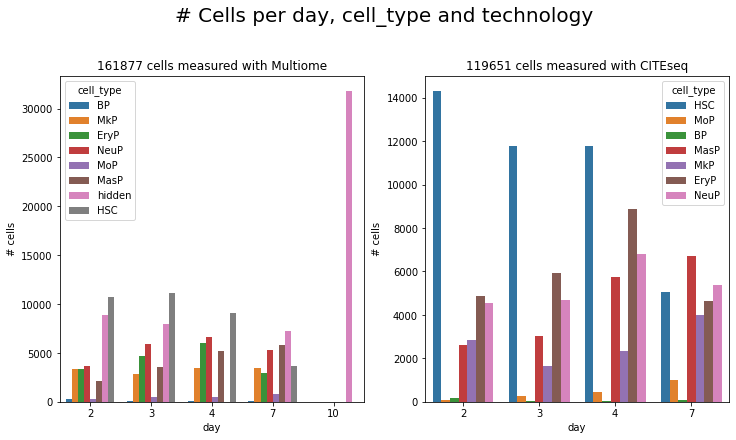

In [ ]:
df_meta_multi = meta_data[meta_data.technology=="multiome"]
df_meta_cite  = meta_data[meta_data.technology=="citeseq"]

fig, axs = plt.subplots(1,2,figsize=(12,6))

df_multi_cell_dist = df_meta_multi[["day","cell_type"]].value_counts().to_frame().sort_values("day").reset_index().rename(columns={0:"# cells"})
sns.barplot(data=df_multi_cell_dist, x="day",hue="cell_type",y="# cells", ax=axs[0])
axs[0].set_title(f"{len(df_meta_multi)} cells measured with Multiome")

df_cite_cell_dist = df_meta_cite[["day","cell_type"]].value_counts().to_frame().sort_values("day").reset_index().rename(columns={0:"# cells"})
sns.barplot(data=df_cite_cell_dist, x="day",hue="cell_type",y="# cells", ax=axs[1])
axs[1].set_title(f"{len(df_meta_cite)} cells measured with CITEseq")

plt.suptitle('# Cells per day, cell_type and technology', y=1.04, fontsize=20)
plt.show()